In [15]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes

In [16]:
import pandas as pd
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import seaborn as sns
from shapely.geometry import Point

In [17]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)
combined_data.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_orvalho_max,...,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,temperatura_min,data,id_estacao,ano,temperatura_max
0,5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.184187,2003-05-26,A412,2003,31.006134
1,5,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.423990,2003-05-27,A412,2003,31.069967
2,5,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.347433,2003-05-27,A412,2003,31.033491
3,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.179983,2003-05-28,A412,2003,31.019276
4,5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.190351,2003-05-29,A412,2003,30.994087


In [18]:
combined_data.columns

Index(['mes', 'hora', 'precipitacao_total', 'pressao_atm_hora',
       'pressao_atm_max', 'pressao_atm_min', 'radiacao_global',
       'temperatura_bulbo_hora', 'temperatura_orvalho_hora',
       'temperatura_orvalho_max', 'temperatura_orvalho_min', 'umidade_rel_max',
       'umidade_rel_min', 'umidade_rel_hora', 'vento_direcao',
       'vento_rajada_max', 'vento_velocidade', 'temperatura_min', 'data',
       'id_estacao', 'ano', 'temperatura_max'],
      dtype='object')

In [19]:
# Abrir o shapefile de estações
gdf_voronoi = gpd.read_file(('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp'))
gdf_voronoi.head()

,id_estacao,latitude,longitude,geometry
0,A336,-8.441667,-43.865556,"MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ..."
1,A365,-8.117939,-42.975721,"MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ..."
2,A416,-13.332500,-44.617500,"MULTIPOLYGON (((-44.05675 -12.61621, -44.05717..."
3,A433,-14.181944,-41.672222,"POLYGON ((-42.21703 -13.71785, -42.21693 -13.7..."
4,A308,-3.086667,-41.783056,"POLYGON ((-41.52190 -3.55804, -41.52253 -3.558..."


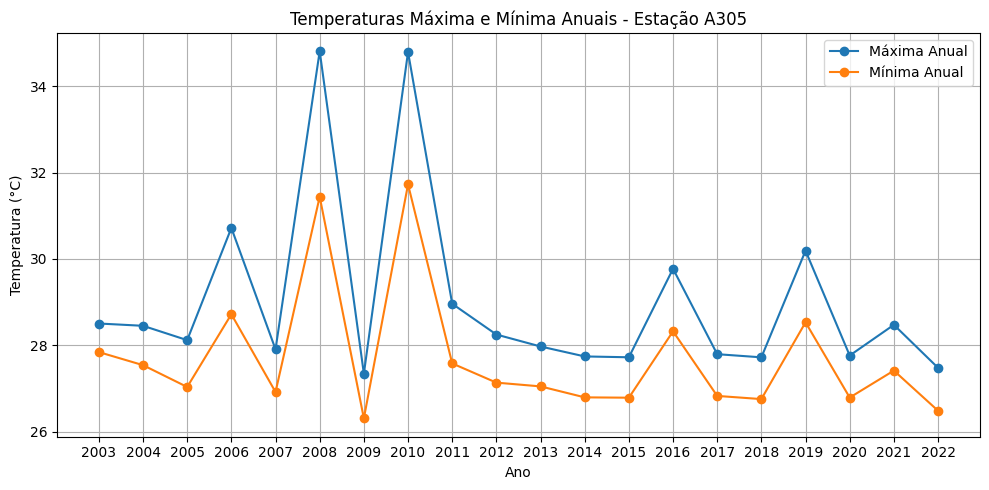

In [21]:
# Filtrar os dados apenas para a estação A305
dados_A305 = combined_data[combined_data['id_estacao'] == 'A305']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('ano').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação A305')
plt.xticks(range(temperatura_anual['ano'].min(), temperatura_anual['ano'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [25]:
# Calcular o aumento da temperatura
temp_increase = combined_data.groupby('id_estacao').apply(lambda x: x[x['ano'] == x['ano'].max()]['temperatura_max'].mean() - x[x['ano'] == x['ano'].min()]['temperatura_max'].mean())
temp_increase = temp_increase.reset_index()
temp_increase.columns = ['id_estacao', 'temp_increase']
temp_increase.head()

,id_estacao,temp_increase
0,A305,-1.026185
1,A306,5.163382
2,A307,2.486618
3,A308,0.431849
4,A309,0.203919


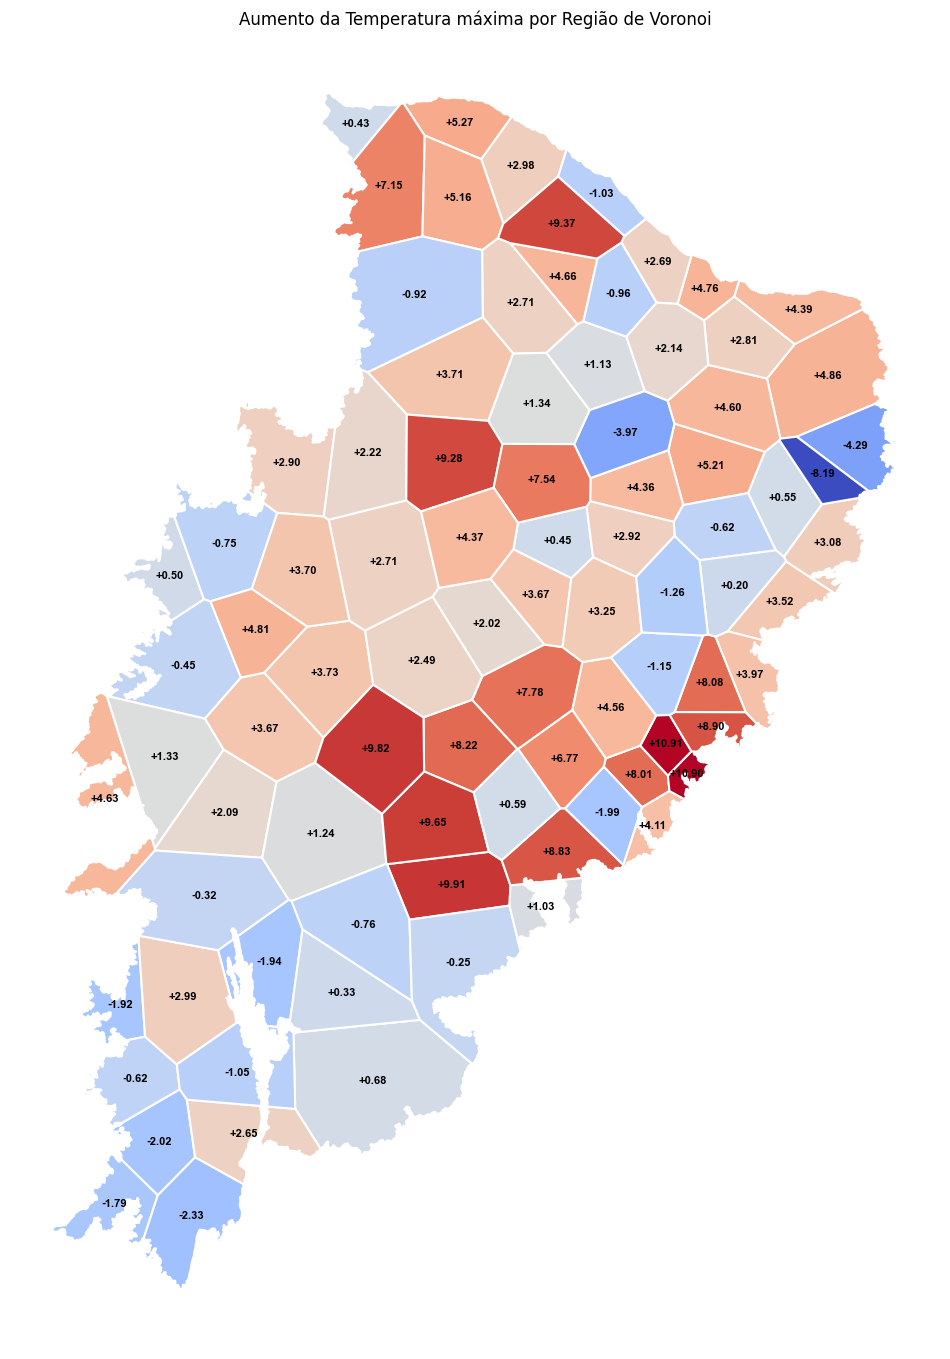

In [35]:
# Visualizar o mapa com bordas mais grossas e adicionar + ou - com a temperatura
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Adicionando espessura às bordas das regiões
gdf_voronoi.plot(column='temp_increase', ax=ax, cmap='coolwarm', edgecolor='white', linewidth=1.5)

# Adicionar + e - com a temperatura em cada região
for idx, row in gdf_voronoi.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    temp_change = row['temp_increase']
    symbol = '+' if temp_change > 0 else '-'
    ax.text(x, y, f"{symbol}{abs(temp_change):.2f}", ha='center', va='center', fontsize=8, fontname='Arial', fontweight='bold', color='black')

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title('Aumento da Temperatura máxima por Região de Voronoi')
plt.show()